In [17]:
import pandas as pd
import statsmodels.api as sm
import platform
import matplotlib.pyplot as plt
import matplotlib as mpl

In [18]:
mpl.rcParams['axes.unicode_minus'] = False
current_os = platform.system()
if current_os == 'Windows':
    plt.rcParams["font.family"] = 'Malgun Gothic'
elif current_os == 'Darwin':
    plt.rcParams["font.family"] = 'AppleGothic'
else:
    plt.rcParams["font.family"] = 'NanumGothic'

In [26]:
data = pd.read_csv('../../data/school_health_preprocessed.csv')
df = data[['하루수면량', '아침식사', 'BMI', '성별', '학교급']].dropna()

sleep_time_mapping = {
    1.0: 5.5,   # 6시간 이내 평균 가정
    2.0: 6.5,   # 6~7시간 평균 가정
    3.0: 7.5,   # 7~8시간 평균 가정
    4.0: 8.5    # 8시간 이상 평균 가정
}
df['수면시간_수치'] = df['하루수면량'].map(sleep_time_mapping)

breakfast_mapping = {1: 4, 2: 3, 3: 2, 4: 1}
df['아침식사_수치'] = df['아침식사'].map(breakfast_mapping)

df['학교급'] = df['학교급'].astype(str)
df['성별'] = df['성별'].astype(str)

In [ ]:
schools = ['초', '중', '고']
genders = ['남', '여']

groups = [(gender, school) for gender in genders for school in schools]

In [ ]:
def perform_regression(group_data, group_name):
    X = group_data[['수면시간_수치', '아침식사_수치']]
    X = sm.add_constant(X)
    y = group_data['BMI']
    
    model = sm.OLS(y, X).fit()
    
    print(f"=== {group_name} 그룹 회귀 결과 ===")
    print(model.summary())
    print("\n")
    
    return model


In [ ]:
# 모든 그룹에 대해 회귀분석 수행
regression_results = {}
for school, gender in groups:
    group_name = f"{school}{gender}"
    group_data = df[(df['학교급'] == school) & (df['성별'] == gender)]
    
    if len(group_data) < 10:
        print(f"=== {group_name} 그룹의 데이터 수가 충분하지 않습니다 ({len(group_data)}개). 회귀분석을 건너뜁니다. ===\n")
        continue
    
    model = perform_regression(group_data, group_name)
    regression_results[group_name] = model
## 결과:
# 남자 초등학생 그룹은 수면시간과 BMI 단일 회귀분석 때보다 0.3% 늘어난 2.3%의 BMI 변동량을 설명할 수 있고,
# 여자 초등학생 그룹은 수면시간과 BMI 단일 회귀분석 때보다 0.6% 늘어난 3.6%의 BMI 변동량을 설명할 수 있음.
# 기타 그룹은 영향이 미미하여 설명 x

=== 초남 그룹 회귀 결과 ===
                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     194.5
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           3.14e-84
Time:                        21:22:29   Log-Likelihood:                -46342.
No. Observations:               16753   AIC:                         9.269e+04
Df Residuals:                   16750   BIC:                         9.271e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.3606      0.321

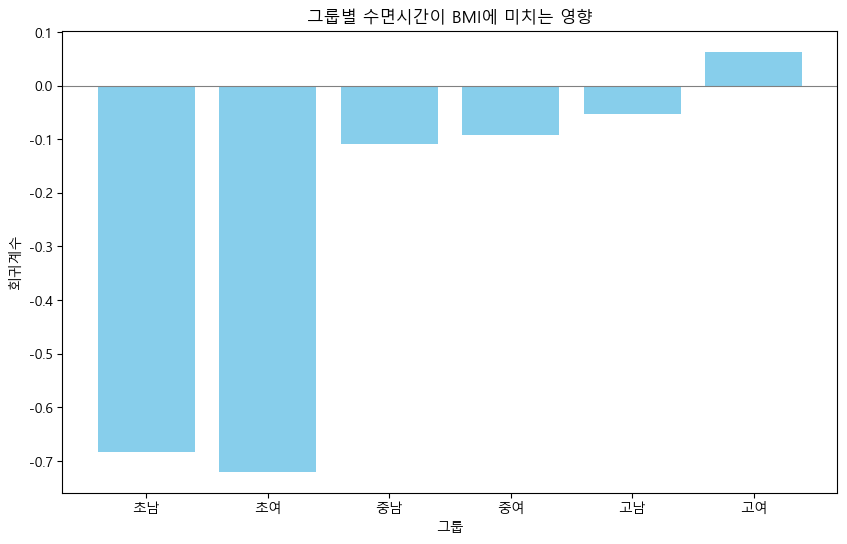

In [ ]:
# 회귀계수 비교 시각화
coefficients = {'그룹': [], '수면시간_수치': [], '아침식사_수치': []}
for group, model in regression_results.items():
    coefficients['그룹'].append(group)
    coefficients['수면시간_수치'].append(model.params['수면시간_수치'])
    coefficients['아침식사_수치'].append(model.params['아침식사_수치'])

coeff_df = pd.DataFrame(coefficients)

# 수면시간 회귀계수 시각화
plt.figure(figsize=(10, 6))
plt.bar(coeff_df['그룹'], coeff_df['수면시간_수치'], color='skyblue')
plt.axhline(0, color='grey', linewidth=0.8)
plt.title('그룹별 수면시간이 BMI에 미치는 영향')
plt.xlabel('그룹')
plt.ylabel('회귀계수')
plt.show()
## 결과: 초등 그룹은 수면시간이 BMI에 영향을 미침

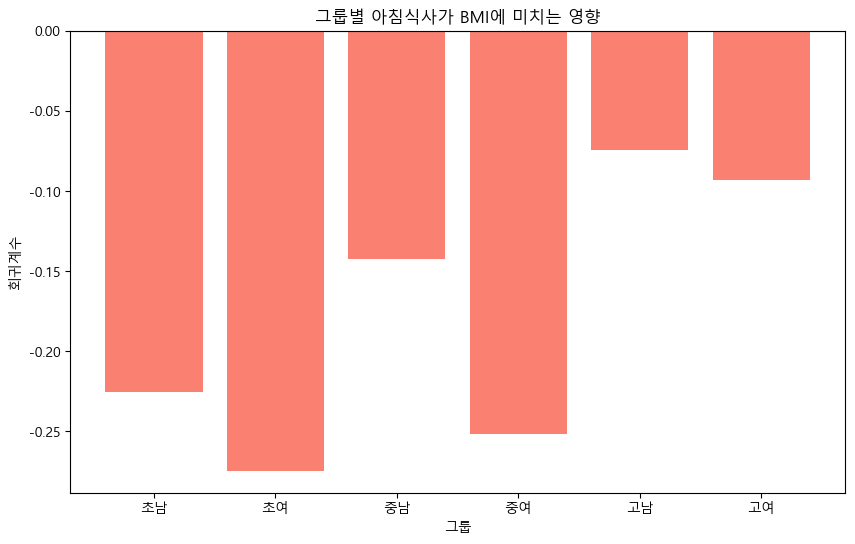

In [ ]:
# 아침식사 회귀계수 시각화
plt.figure(figsize=(10, 6))
plt.bar(coeff_df['그룹'], coeff_df['아침식사_수치'], color='salmon')
plt.axhline(0, color='grey', linewidth=0.8)
plt.title('그룹별 아침식사가 BMI에 미치는 영향')
plt.xlabel('그룹')
plt.ylabel('회귀계수')
plt.show()
## 결과: 초~중 그룹은 아침식사가 BMI에 영향을 미침